In [204]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import numpy as np
from scipy import stats
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
BUCKET = 'ikh-nart'
#BUCKET = 'rio-mora'

if BUCKET=='ikh-nart':
    alias = 'wdpa-99848'
    datadir = f'/datadrive/{BUCKET}/data/{alias}/'
    climatefile = f'{datadir}/TERRACLIMATE_{alias}_v1_long_2019-12-01.csv' 
    landsatfile = f'{datadir}/LANDSAT_NDVI_EVI_{alias}_v1_long_2020-06-01.csv'
    ndvi = pd.read_csv(landsatfile)
    points = pd.read_csv(f'{datadir}/{alias}_points_v1.csv')
else:
    alias = 'wdpa-555609346'
    datadir = f'/datadrive/{BUCKET}/data/{alias}/'
    climatefile = f'{datadir}/TERRACLIMATE_{alias}_v1_long_2019-12-01.csv' 
    landsatfile = f'{datadir}/LANDSAT_NDVI_EVI_{alias}_v1_long_2020-06-02.csv'
    ndvi = pd.read_csv(landsatfile)
    
ds = pd.read_csv(climatefile)
ds.index = pd.to_datetime(ds.index)
ndvi.index = pd.to_datetime(ndvi.img_date)

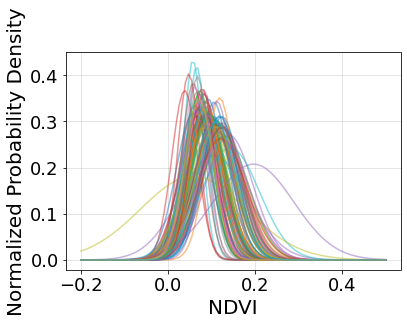

In [206]:
#plot the distribution of ndvis for each point to determine representative samples
pnts = np.unique(ndvi.loc_id)
f, ax = plt.subplots(1,1,figsize=(6,4))
means = np.zeros(len(pnts)) 
stds = np.zeros(len(pnts))
for i, p in enumerate(pnts):
    pnt = ndvi[ndvi.loc_id==p]
    m, s = stats.norm.fit(pnt.NDVI)
    means[i] = m
    stds[i] = s
    if BUCKET == 'ikh-nart':
        vmin, vmax = -0.2, 0.5
    else:
        vmin, vmax = -0.2, 0.9
    lnspc = np.linspace(vmin,vmax,100)
    pdf_norm = stats.norm.pdf(lnspc, m, s)
    #a,b,c = stats.gamma.fit(pnt.NDVI)
    #pdf_gamma = stats.gamma.pdf(lnspc, a,b,c)
    ax.plot(lnspc, pdf_norm/np.linalg.norm(pdf_norm), label='point %s'%p, alpha=0.5)
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel('NDVI', fontsize=20)
ax.set_ylabel('Normalized Probability Density', fontsize=20)
ax.grid(alpha=0.4)

In [207]:
#get the 90th percentiles and mean
mu = np.median(means)
sig = np.median(stds)
lower = np.percentile(means, 5)
upper = np.percentile(means, 95)

thr = 0.01
med_pnts = pnts[(means >=mu-thr) & (means <= mu+thr)][:2]
lower_pnts = pnts[(means >=lower-thr) & (means <= lower+thr)][:2]
upper_pnts = pnts[(means >=upper-thr) & (means <= upper+thr)][:2]
rep_pnts = np.array([lower_pnts, med_pnts, upper_pnts]).flatten()
#points[points.loc_id==rep_pnts]

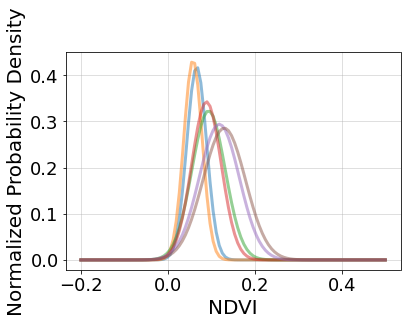

In [208]:
#try ploting again with these points
#plot the distribution of ndvis for each point to determine representative samples
f, ax = plt.subplots(1,1,figsize=(6,4))
for p in rep_pnts:
    pnt = ndvi[ndvi.loc_id==p]
    m, s = stats.norm.fit(pnt.NDVI)
    lnspc = np.linspace(-0.2,0.5,100)
    pdf_norm = stats.norm.pdf(lnspc, m, s)
    #a,b,c = stats.gamma.fit(pnt.NDVI)
    #pdf_gamma = stats.gamma.pdf(lnspc, a,b,c)
    ax.plot(lnspc, pdf_norm/np.linalg.norm(pdf_norm), label='point %s'%p, alpha=0.5, lw=3)
#ax.legend(fontsize=18)
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel('NDVI', fontsize=20)
ax.set_ylabel('Normalized Probability Density', fontsize=20)
ax.grid(alpha=0.5)

In [209]:
ndvi_mu = ndvi.groupby(ndvi.index).agg('median')
ndvi_mu.index = pd.to_datetime(ndvi_mu.index)
enddate='20200602'
df = ds.groupby(['img_date']).agg('median')
df.index = pd.to_datetime(df.index)
subdf = df['19801201':enddate]

In [210]:
ts ='1m'
ndvi_resample = ndvi_mu.resample(ts).median()
var = 'pdsi'
ndvi_resample['abv'] = ndvi_resample['NDVI']
ndvi_resample['bel'] = ndvi_resample['NDVI']
ndvi_mean = np.mean(ndvi_resample.NDVI)
ndvi_resample.abv[ndvi_resample.abv<ndvi_mean] = ndvi_mean
ndvi_resample.bel[ndvi_resample.bel>ndvi_mean] = ndvi_mean
ndvi_resample.bel[np.isnan(ndvi_resample.bel)] = ndvi_mean
ndvi_resample.abv[np.isnan(ndvi_resample.abv)] = ndvi_mean

climate_resample = subdf[[var]].resample(ts).median()/100
climate_resample['abv'] = climate_resample[var]
climate_resample['bel'] = climate_resample[var]
climate_mean = np.mean(climate_resample[var])
climate_resample.abv[climate_resample.abv<climate_mean] = climate_mean
climate_resample.bel[climate_resample.bel>climate_mean] = climate_mean
climate_resample.bel[np.isnan(climate_resample.bel)] = climate_mean
climate_resample.abv[np.isnan(climate_resample.abv)] = climate_mean

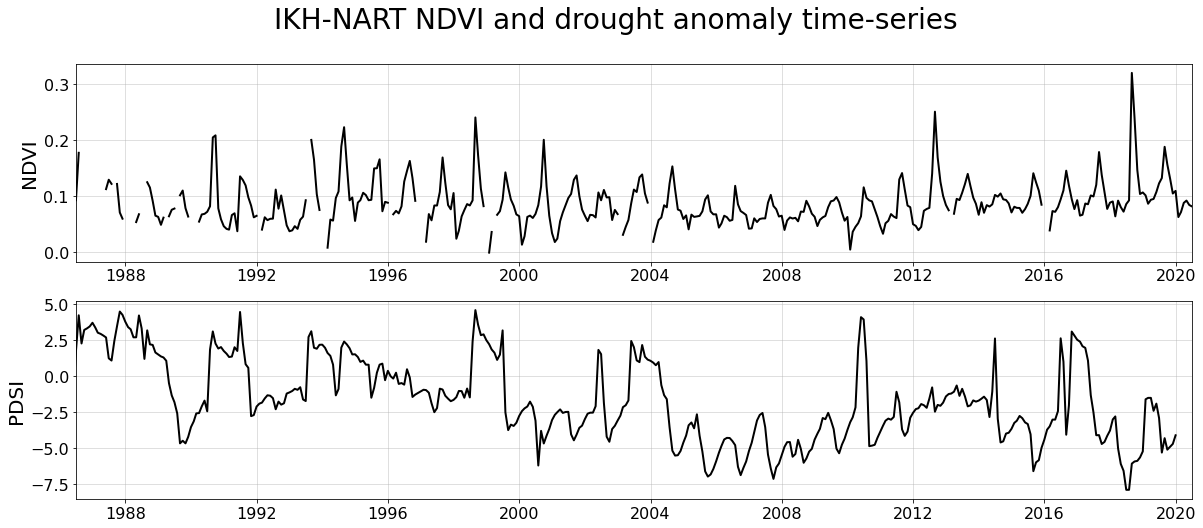

In [211]:
f, ax = plt.subplots(2,1,figsize=(20,8))
ax[0].plot(ndvi_resample.index, ndvi_resample['NDVI'], \
           color='black', lw=2)
ax[1].plot(climate_resample.index, climate_resample[var],\
           color='black', lw=2)

ax[0].grid(alpha=0.5)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_ylabel('NDVI', fontsize=20)

ax[1].grid(alpha=0.5)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_ylabel('PDSI', fontsize=20)
ax[0].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[1].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
f.suptitle(f'{BUCKET.upper()} NDVI and drought anomaly time-series',\
          fontsize=28)
f.savefig(f'./out/{BUCKET}_NDVI_climate_series_no_fill.png', dpi=300, bbox_inches='tight')

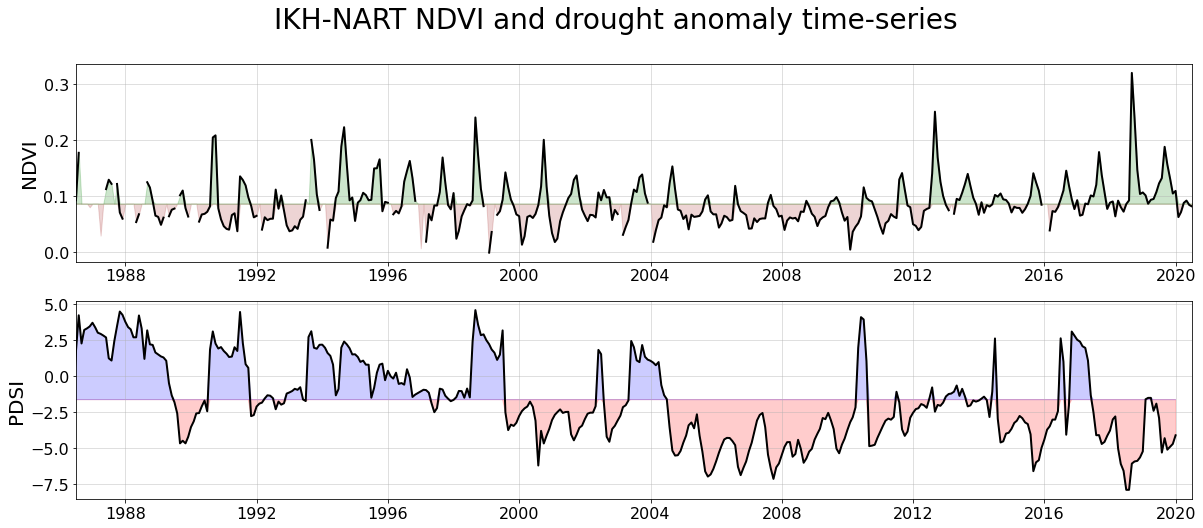

In [212]:
f, ax = plt.subplots(2,1,figsize=(20,8))
ax[0].plot(ndvi_resample.index, ndvi_resample['NDVI'], \
           color='black', lw=2)
ax[1].plot(climate_resample.index, climate_resample[var],\
           color='black', lw=2)
ax[0].fill_between(ndvi_resample.index, \
                   ndvi_mean, \
                   ndvi_resample['bel'], color='brown', alpha=0.2)
ax[0].fill_between(ndvi_resample.index, \
                   ndvi_mean, \
                   ndvi_resample['abv'], color='green', alpha=0.2)
ax[0].grid(alpha=0.5)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_ylabel('NDVI', fontsize=20)
ax[1].fill_between(climate_resample.index, \
                   climate_mean, \
                   climate_resample['bel'], color='red', alpha=0.2)
ax[1].fill_between(climate_resample.index, \
                   climate_mean, \
                   climate_resample['abv'], color='blue', alpha=0.2)

ax[1].grid(alpha=0.5)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_ylabel('PDSI', fontsize=20)
ax[0].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[1].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
f.suptitle(f'{BUCKET.upper()} NDVI and drought anomaly time-series',\
          fontsize=28)
f.savefig(f'./out/{BUCKET}_NDVI_climate_series.png', dpi=300, bbox_inches='tight')

In [213]:
ts = '1y'
ndvi_resample = ndvi_mu.resample(ts).mean()
tmp_sample = df[['tmmn','tmmx']].resample(ts).mean()*0.1
tmp_sample['tmean']=(tmp_sample.tmmn+tmp_sample.tmmx)/2

pr_sample = df[['pr']].resample(ts).sum()

def get_anomaly(sample, var):
    anom = sample.copy()
    anom['abv'] = anom[var] 
    anom['bel'] = anom[var]
    mu = np.mean(anom[var])
    anom.abv[anom.abv<mu] = mu
    anom.bel[anom.bel>=mu] = mu
    anom.bel[np.isnan(anom.bel)] = mu
    anom.abv[np.isnan(anom.abv)] = mu
    return(anom,mu)

tmp_sample,tmp_mu = get_anomaly(tmp_sample, 'tmean')
tmx_sample,tmx_mu = get_anomaly(tmp_sample, 'tmmx')
tmn_sample,tmn_mu = get_anomaly(tmp_sample, 'tmmn')
pr_sample,pr_mu = get_anomaly(pr_sample, 'pr')

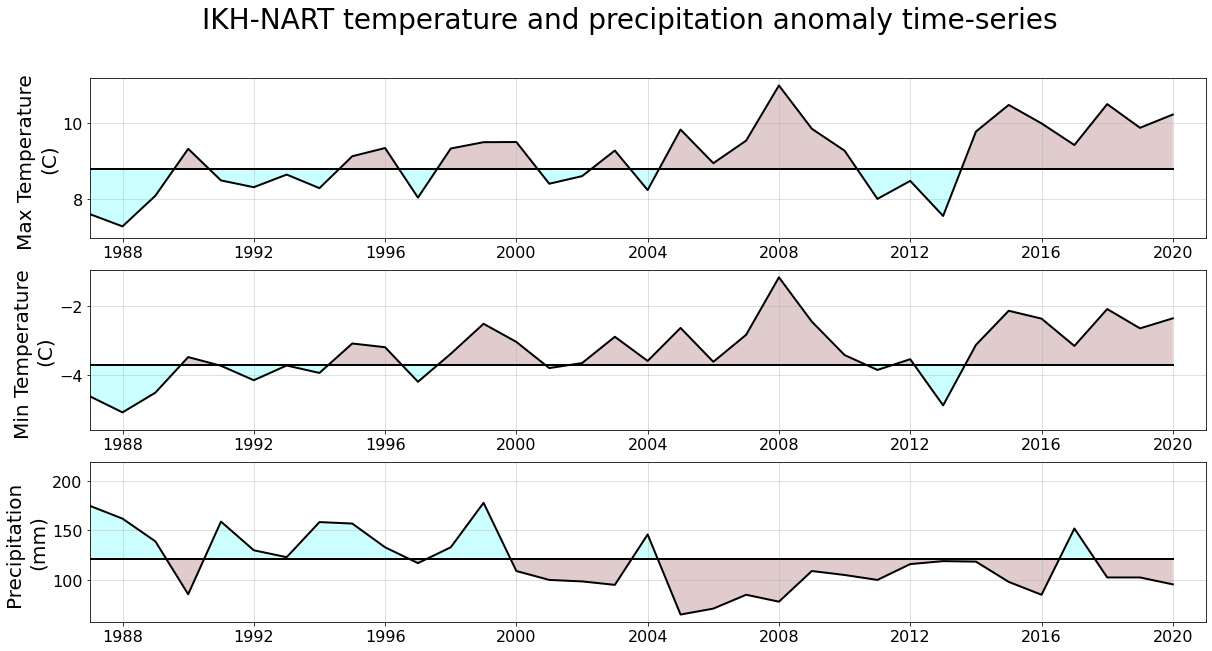

In [214]:
f,ax = plt.subplots(3,1,figsize=(20,10))
 
tmx_mu_array =np.ones(len(tmx_sample))*tmx_mu
tmn_mu_array =np.ones(len(tmn_sample))*tmn_mu
pr_mu_array = np.ones(len(pr_sample))*pr_mu
ax[0].plot(tmx_sample.index, tmx_sample.tmmx, color='black', lw=2)
ax[0].plot(tmx_sample.index, tmx_mu_array, color='black', lw=2)
ax[0].fill_between(tmx_sample.index, tmx_sample.tmmx, tmx_mu_array,\
                   where=tmx_mu_array>=tmx_sample.tmmx,facecolor='#00ffff',interpolate=True, alpha=0.2)
ax[0].fill_between(tmx_sample.index, tmx_sample.tmmx, tmx_mu_array,\
                   where=tmx_mu_array<=tmx_sample.tmmx,facecolor='#660000',interpolate=True, alpha=0.2)

ax[1].plot(tmn_sample.index, tmn_sample.tmmn, color='black', lw=2)
ax[1].plot(tmx_sample.index, tmn_mu_array, color='black', lw=2)
ax[1].fill_between(tmn_sample.index, tmn_sample.tmmn, tmn_mu_array,\
                   where=tmn_mu_array>=tmn_sample.tmmn,facecolor='#00ffff',interpolate=True, alpha=0.2)
ax[1].fill_between(tmn_sample.index, tmn_sample.tmmn, tmn_mu_array,\
                   where=tmn_mu_array<=tmx_sample.tmmn,facecolor='#660000',interpolate=True, alpha=0.2)


ax[2].plot(pr_sample.index, pr_sample.pr, color='black', lw=2)
ax[2].plot(pr_sample.index, pr_mu_array, color='black', lw=2)
ax[2].fill_between(pr_sample.index, pr_sample.pr, pr_mu_array,\
                   where=pr_mu_array>=pr_sample.pr,facecolor='#660000',interpolate=True, alpha=0.2)
ax[2].fill_between(pr_sample.index, pr_sample.pr, pr_mu_array,\
                   where=pr_mu_array<=pr_sample.pr,facecolor='#00ffff',interpolate=True, alpha=0.2)

ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
ax[2].grid(alpha=0.5)
ax[0].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[1].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[2].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[0].tick_params(axis='both', labelsize=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[2].tick_params(axis='both', labelsize=16)

ax[0].set_ylabel('Max Temperature \n(C)', fontsize=20)
ax[1].set_ylabel('Min Temperature \n(C)', fontsize=20)
ax[2].set_ylabel('Precipitation \n(mm)', fontsize=20)
f.suptitle(f'{BUCKET.upper()} temperature and precipitation anomaly time-series',\
          fontsize=28)
f.savefig(f'./out/{BUCKET}_tmp_pr_climate_series.png', dpi=300, bbox_inches='tight')

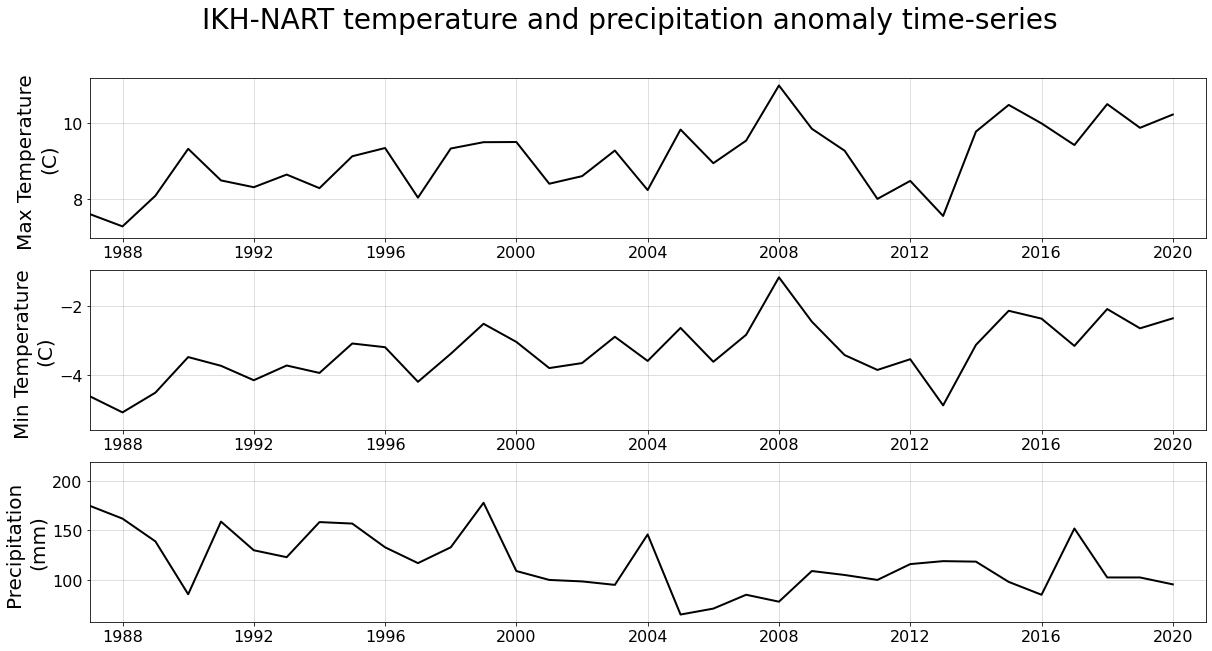

In [215]:
f,ax = plt.subplots(3,1,figsize=(20,10))
'''
ax[0].fill_between(tmx_sample.index, \
                   tmx_mu, \
                   tmx_sample.bel, color='#00ffff')
ax[0].fill_between(tmx_sample.index, \
                   tmx_mu, \
                   tmx_sample.abv, color='#660000')
ax[1].fill_between(tmn_sample.index, \
                   tmn_mu, \
                   tmn_sample.bel, color='#00ffff')
ax[1].fill_between(tmn_sample.index, \
                   tmn_mu, \
                   tmn_sample.abv, color='#660000')

ax[2].fill_between(pr_sample.index, \
                   pr_mu, \
                   pr_sample.bel, color='#660000')
ax[2].fill_between(pr_sample.index, \
                   pr_mu, \
                   pr_sample.abv, color='#00ffff')
''' 
tmx_mu_array =np.ones(len(tmx_sample))*tmx_mu
tmn_mu_array =np.ones(len(tmn_sample))*tmn_mu
pr_mu_array = np.ones(len(pr_sample))*pr_mu
ax[0].plot(tmx_sample.index, tmx_sample.tmmx, color='black', lw=2)

ax[1].plot(tmn_sample.index, tmn_sample.tmmn, color='black', lw=2)


ax[2].plot(pr_sample.index, pr_sample.pr, color='black', lw=2)

ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
ax[2].grid(alpha=0.5)
ax[0].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[1].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[2].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[0].tick_params(axis='both', labelsize=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[2].tick_params(axis='both', labelsize=16)

ax[0].set_ylabel('Max Temperature \n(C)', fontsize=20)
ax[1].set_ylabel('Min Temperature \n(C)', fontsize=20)
ax[2].set_ylabel('Precipitation \n(mm)', fontsize=20)
f.suptitle(f'{BUCKET.upper()} temperature and precipitation anomaly time-series',\
          fontsize=28)
f.savefig(f'./out/{BUCKET}_tmp_pr_climate_series_no_fill.png', dpi=300, bbox_inches='tight')

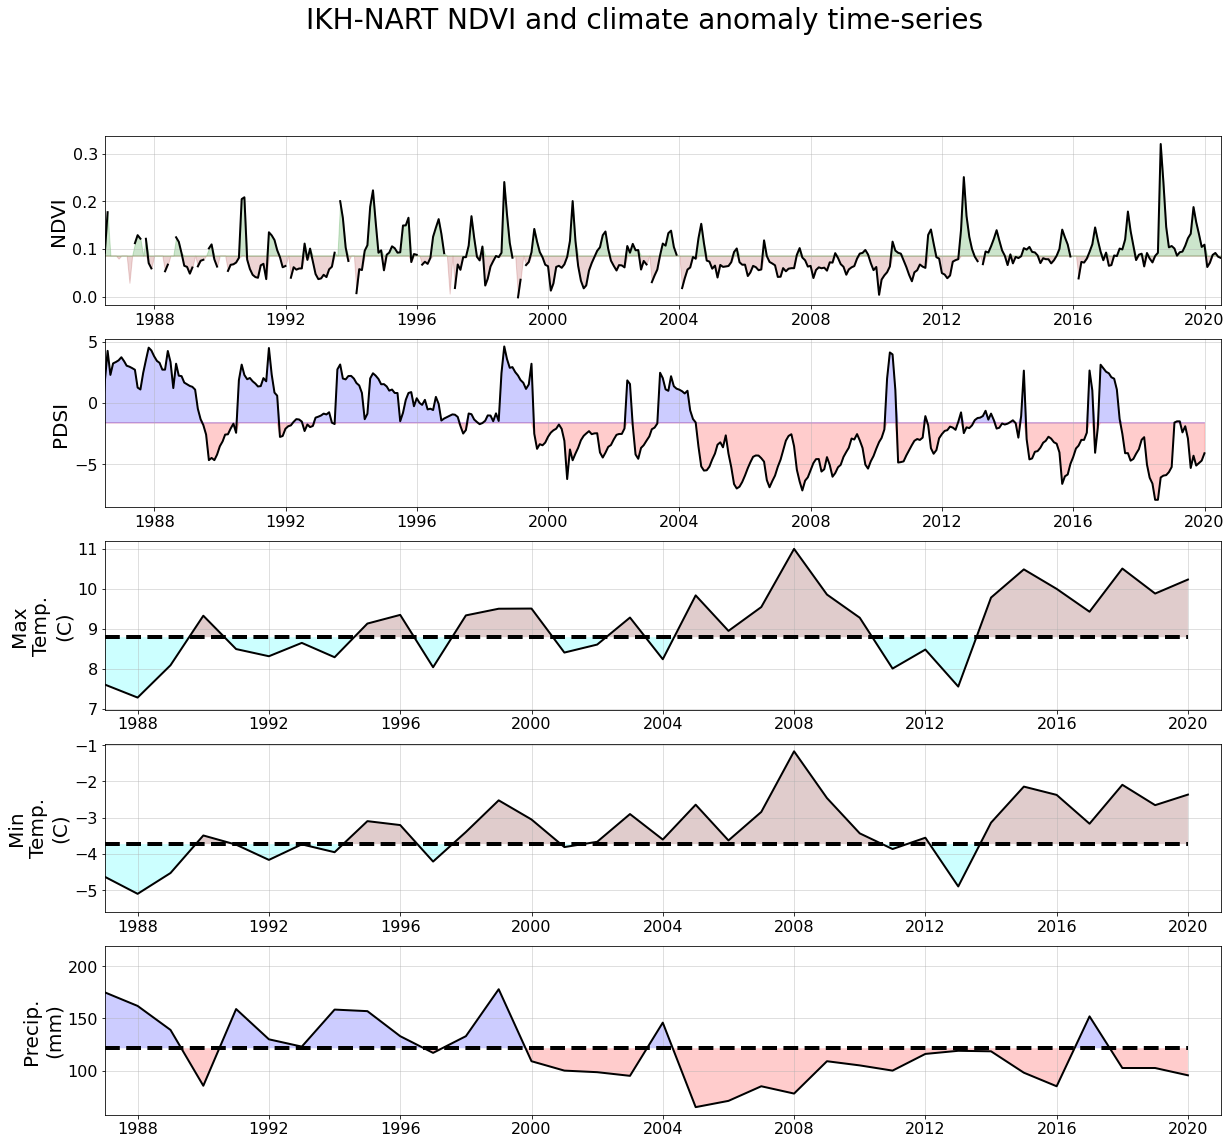

In [217]:
f, ax = plt.subplots(5,1,figsize=(20,18))
ts ='1m'
ndvi_resample = ndvi_mu.resample(ts).median()
var = 'pdsi'
ndvi_resample['abv'] = ndvi_resample['NDVI']
ndvi_resample['bel'] = ndvi_resample['NDVI']
ndvi_mean = np.mean(ndvi_resample.NDVI)
ndvi_resample.abv[ndvi_resample.abv<ndvi_mean] = ndvi_mean
ndvi_resample.bel[ndvi_resample.bel>ndvi_mean] = ndvi_mean
ndvi_resample.bel[np.isnan(ndvi_resample.bel)] = ndvi_mean
ndvi_resample.abv[np.isnan(ndvi_resample.abv)] = ndvi_mean

ax[0].plot(ndvi_resample.index, ndvi_resample['NDVI'], \
           color='black', lw=2)
ax[1].plot(climate_resample.index, climate_resample[var],\
           color='black', lw=2)
ax[0].fill_between(ndvi_resample.index, \
                   ndvi_mean, \
                   ndvi_resample['bel'], color='brown', alpha=0.2)
ax[0].fill_between(ndvi_resample.index, \
                   ndvi_mean, \
                   ndvi_resample['abv'], color='green', alpha=0.2)
ax[0].grid(alpha=0.5)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_ylabel('NDVI', fontsize=20)
ax[1].fill_between(climate_resample.index, \
                   climate_mean, \
                   climate_resample['bel'], color='red', alpha=0.2)
ax[1].fill_between(climate_resample.index, \
                   climate_mean, \
                   climate_resample['abv'], color='blue', alpha=0.2)

ax[1].grid(alpha=0.5)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_ylabel('PDSI', fontsize=20)
ax[0].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[1].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])

ts = '1y'
ndvi_resample = ndvi_mu.resample(ts).mean()

ax[2].plot(tmx_sample.index, tmx_sample.tmmx, color='black', lw=2)
ax[2].plot(tmx_sample.index, tmx_mu_array, color='black', ls='--', lw=4)
ax[2].fill_between(tmx_sample.index, tmx_sample.tmmx, tmx_mu_array,\
                   where=tmx_mu_array>=tmx_sample.tmmx,facecolor='#00ffff',\
                   alpha=0.2,interpolate=True)
ax[2].fill_between(tmx_sample.index, tmx_sample.tmmx, tmx_mu_array,\
                   where=tmx_mu_array<=tmx_sample.tmmx,facecolor='#660000',\
                   alpha=0.2,interpolate=True)

ax[3].plot(tmn_sample.index, tmn_sample.tmmn, color='black', lw=2)
ax[3].plot(tmx_sample.index, tmn_mu_array, color='black', ls='--', lw=4)
ax[3].fill_between(tmn_sample.index, tmn_sample.tmmn, tmn_mu_array,\
                   where=tmn_mu_array>=tmn_sample.tmmn,facecolor='#00ffff',\
                   alpha=0.2,interpolate=True)
ax[3].fill_between(tmn_sample.index, tmn_sample.tmmn, tmn_mu_array,\
                   where=tmn_mu_array<=tmx_sample.tmmn,facecolor='#660000',\
                   alpha=0.2,interpolate=True)

ax[4].plot(pr_sample.index, pr_sample.pr, color='black', lw=2)
ax[4].plot(pr_sample.index, pr_mu_array, color='black', ls='--', lw=4)
ax[4].fill_between(pr_sample.index, pr_sample.pr, pr_mu_array,\
                   where=pr_mu_array>=pr_sample.pr,facecolor='red',\
                   alpha=0.2,interpolate=True)
ax[4].fill_between(pr_sample.index, pr_sample.pr, pr_mu_array,\
                   where=pr_mu_array<=pr_sample.pr,facecolor='blue',\
                   alpha=0.2,interpolate=True)

ax[2].grid(alpha=0.5)
ax[3].grid(alpha=0.5)
ax[4].grid(alpha=0.5)
ax[2].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[3].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[4].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[2].tick_params(axis='both', labelsize=16)
ax[3].tick_params(axis='both', labelsize=16)
ax[4].tick_params(axis='both', labelsize=16)

ax[2].set_ylabel('Max\nTemp.\n(C)', fontsize=20)
ax[3].set_ylabel('Min\nTemp.\n(C)', fontsize=20)
ax[4].set_ylabel('Precip.\n(mm)', fontsize=20)
f.suptitle(f'{BUCKET.upper()} NDVI and climate anomaly time-series',\
          fontsize=28)
f.savefig(f'./out/{BUCKET}_summary_series.png', dpi=300, bbox_inches='tight')

In [ ]:
#open up the climate data for RCP8.5

In [ ]:
gcmfile = f'{datadir}/GDDP_rcp85_wdpa-99848_v1.csv'
gcm = pd.read_csv(gcmfile)

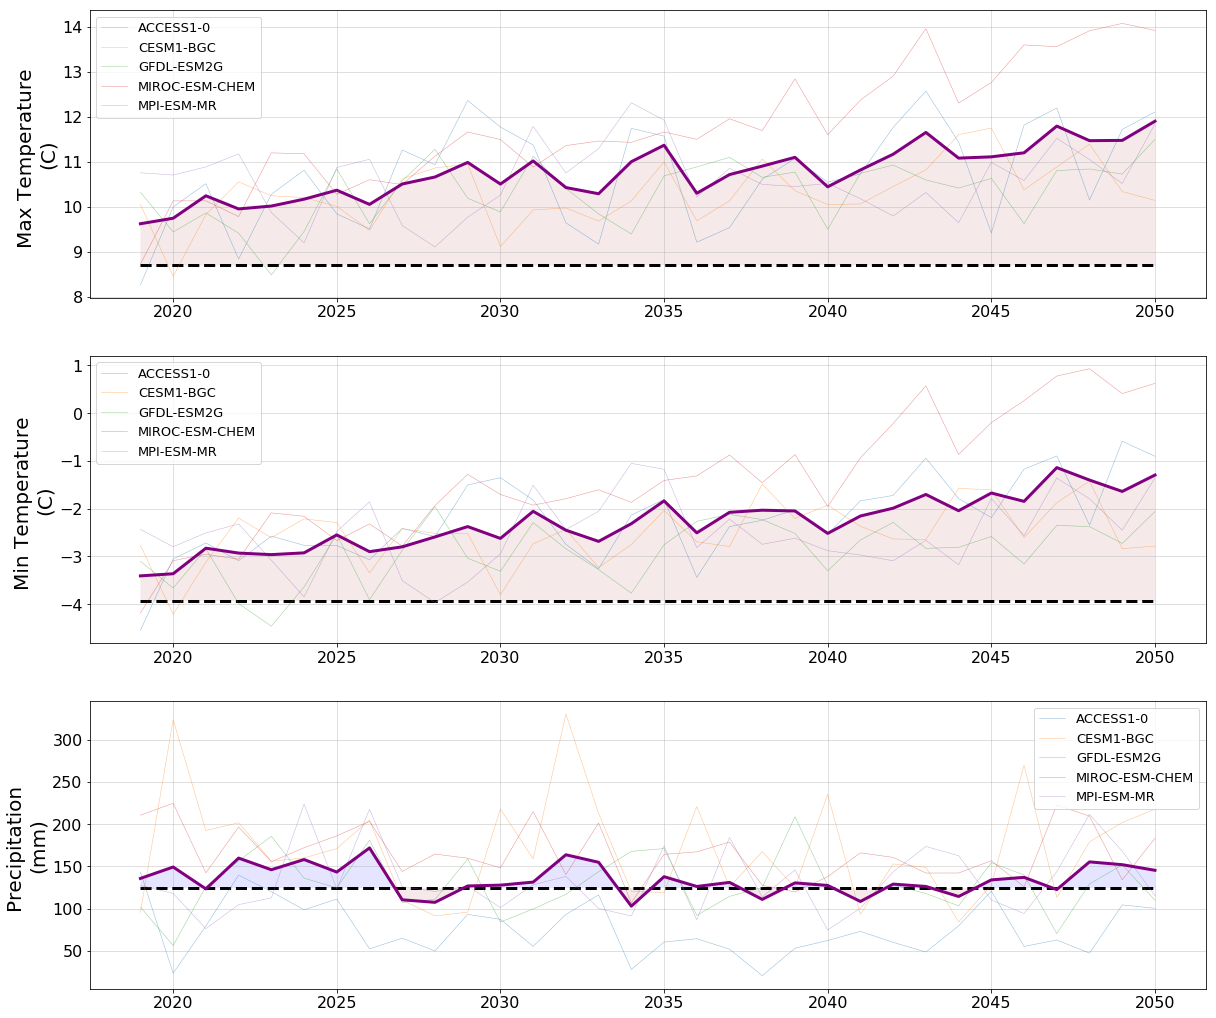

In [32]:
import rasterio
from glob import glob
model_l = ['ACCESS1-0', 'CESM1-BGC', 'GFDL-ESM2G', 'MIROC-ESM-CHEM', 'MPI-ESM-MR' ]
model = ['access', 'cesm', 'gfdl', 'miroc', 'mpi']

year = np.arange(2019,2051)
tmx_mu_arr =np.ones(len(year))*tmx_mu
tmn_mu_arr =np.ones(len(year))*tmn_mu
pr_mu_arr = np.ones(len(year))*pr_mu

f,ax = plt.subplots(3,1,figsize=(20,18))
ax[0].plot(year,tmx_mu_arr,ls='--',lw=3, color='black')
ax[1].plot(year,tmn_mu_arr,ls='--',lw=3, color='black')
ax[2].plot(year,pr_mu_arr,ls='--',lw=3, color='black')
tmx_avg = []
tmn_avg = []
pr_avg = []
for m,ml in zip(model,model_l):
    k = sorted(glob('./data/projections/*%s*tas*.tif'%m))
    m_imgs = [rasterio.open(i) for i in k]
    tasmin = np.array([np.mean(i.read(1))-273.15 for i in m_imgs])
    tmn_avg.append(tasmin)
    tasmax = np.array([np.mean(i.read(2))-273.15 for i in m_imgs])
    tmx_avg.append(tasmax)
    k = sorted(glob('./data/projections/*%s*pr*.tif'%m))
    m_imgs = [rasterio.open(i) for i in k]
    pr = np.array([np.mean(i.read(1))*86400 for i in m_imgs])
    pr_avg.append(pr)
    ax[0].plot(year, tasmax, alpha=0.5, label='%s'%ml, lw=0.5)
    ax[1].plot(year, tasmin, alpha=0.5, label='%s'%ml, lw=0.5)
    ax[2].plot(year, pr, alpha=0.5, label='%s'%ml, lw=0.5)
tmx_avg = np.array(tmx_avg)
tmn_avg = np.array(tmn_avg)
pr_avg = np.array(pr_avg)
tmx_ens = np.mean(tmx_avg,axis=0)
tmn_ens = np.mean(tmn_avg,axis=0)
pr_ens = np.mean(pr_avg,axis=0)

ax[0].plot(year,tmx_ens, lw=3, color='purple')
ax[1].plot(year,tmn_ens, lw=3, color='purple')
ax[2].plot(year,pr_ens, lw=3, color='purple')
ax[0].fill_between(year, tmx_ens, tmx_mu_arr,\
                   where=tmx_mu_arr<=tmx_ens, facecolor='brown', alpha=0.1,interpolate=True)
ax[1].fill_between(year, tmn_ens, tmn_mu_arr,\
                   where=tmn_mu_arr<=tmn_ens, facecolor='brown', alpha=0.1,interpolate=True)
ax[2].fill_between(year, pr_ens, pr_mu_arr,\
                   where=pr_mu_arr<=pr_ens, facecolor='blue', alpha=0.1,interpolate=True)
ax[2].fill_between(year, pr_ens, pr_mu_arr,\
                   where=pr_mu_arr>=pr_ens, facecolor='brown', alpha=0.1,interpolate=True)

ax[0].tick_params(axis='both', labelsize=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[2].tick_params(axis='both', labelsize=16)
ax[0].legend(fontsize=13)
ax[1].legend(fontsize=13)
ax[2].legend(fontsize=13)
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
ax[2].grid(alpha=0.5)

ax[0].set_ylabel('Max Temperature \n(C)', fontsize=20)
ax[1].set_ylabel('Min Temperature \n(C)', fontsize=20)
ax[2].set_ylabel('Precipitation \n(mm)', fontsize=20)
f.savefig('./out/projection_timeseries.png', bbox_width='tight', dpi=300)

In [48]:
from src import tools
wd = '/datadrive/csv'
s = 'rcp45'
f = glob(f'{wd}/*{s}*')[0]
gcms = tools.create_gcm_summary(f, (2019,2099))
model_list = np.unique(np.array([i[0] for i in gcms.columns.values]))

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

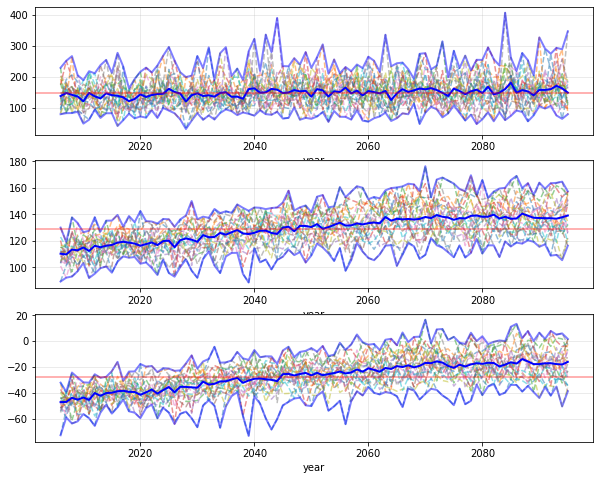

In [47]:
climate_vars = gcms.columns.levels[-1].values
f, ax = plt.subplots(len(climate_vars),1,figsize=(10,8))
for i, var in enumerate(climate_vars):
    summary = gcms.groupby('year').agg('sum').xs(var, level='climate', axis=1)
    summary.plot(ax=ax[i], ls='--',alpha=0.5, legend=False)
    summary.agg('mean', axis=1).plot(ax=ax[i], lw=2, color='blue')
    summary.agg('max', axis=1).plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    summary.agg('min', axis=1).plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    ax[i].axhline(summary.agg('mean', axis=1).mean(), color='red', alpha=0.3, lw=2)
    ax[i].grid(alpha=0.3)

In [84]:
d = {'pr':[], 'tasmax':[], 'tasmin':[]}
for m in model_list:
    for var in climate_vars:
        d[var].append(gcms.groupby('year').agg('sum').xs(var, level='climate', axis=1)[m].values)

In [85]:
d

{'pr': [array([161.18922987,  72.23471859, 155.83479412, 107.01439106,
         164.5156294 , 122.33612092, 201.72578044, 210.95744269,
         114.81820576, 141.57358459, 169.56782146,  95.52428695,
         130.8175138 , 204.55276205, 136.57396365, 153.86848139,
         126.35749495, 113.67630048,  96.41477318, 125.38184256,
         107.42452846, 107.08051742, 156.12367423, 154.90594405,
         178.47360123, 132.31861748,  65.37950842,  67.73185876,
         163.4087012 ,  98.68190536, 112.64042724, 101.51561672,
          97.84332331, 139.20308   , 119.78670775, 117.85341532,
          91.41875045, 222.88488661,  71.12647427, 105.125071  ,
          61.27075277,  55.47631644, 203.54495186,  72.37308821,
         116.49269789,  95.36311686,  70.64242133, 218.77091289,
          94.06518534, 169.42407486, 169.30834707, 155.63162256,
         121.351648  , 185.64542177, 191.44239452, 115.4925751 ,
         123.38805205,  89.69629989,  59.12760546, 124.34660984,
         177.378800

In [38]:
import rasterio

wd = '/datadrive/csv'
gcms = pd.read_csv(f'{wd}/GDDP_processed.csv')
year = np.arange(2019,2051)

tmx_mu_arr =np.ones(len(year))*tmx_mu
tmn_mu_arr =np.ones(len(year))*tmn_mu
pr_mu_arr = np.ones(len(year))*pr_mu

f,ax = plt.subplots(3,1,figsize=(20,18))
ax[0].plot(year,tmx_mu_arr,ls='--',lw=3, color='black')
ax[1].plot(year,tmn_mu_arr,ls='--',lw=3, color='black')
ax[2].plot(year,pr_mu_arr,ls='--',lw=3, color='black')
tmx_avg = []
tmn_avg = []
pr_avg = []
for m in model_list:
    k = sorted(glob('./data/projections/*%s*tas*.tif'%m))
    m_imgs = [rasterio.open(i) for i in k]
    tasmin = np.array([np.mean(i.read(1))-273.15 for i in m_imgs])
    tmn_avg.append(tasmin)
    tasmax = np.array([np.mean(i.read(2))-273.15 for i in m_imgs])
    tmx_avg.append(tasmax)
    k = sorted(glob('./data/projections/*%s*pr*.tif'%m))
    m_imgs = [rasterio.open(i) for i in k]
    pr = np.array([np.mean(i.read(1))*86400 for i in m_imgs])
    pr_avg.append(pr)
    ax[0].plot(year, tasmax, alpha=0.5, label='%s'%ml, lw=0.5)
    ax[1].plot(year, tasmin, alpha=0.5, label='%s'%ml, lw=0.5)
    ax[2].plot(year, pr, alpha=0.5, label='%s'%ml, lw=0.5)
'''
tmx_avg = np.array(tmx_avg)
tmn_avg = np.array(tmn_avg)
pr_avg = np.array(pr_avg)
tmx_ens = np.mean(tmx_avg,axis=0)
tmn_ens = np.mean(tmn_avg,axis=0)
pr_ens = np.mean(pr_avg,axis=0)
ax[0].plot(year,tmx_ens, lw=3, color='purple')
ax[1].plot(year,tmn_ens, lw=3, color='purple')
ax[2].plot(year,pr_ens, lw=3, color='purple')
ax[0].fill_between(year, tmx_ens, tmx_mu_arr,\
                   where=tmx_mu_arr<=tmx_ens, facecolor='brown', alpha=0.1,interpolate=True)
ax[1].fill_between(year, tmn_ens, tmn_mu_arr,\
                   where=tmn_mu_arr<=tmn_ens, facecolor='brown', alpha=0.1,interpolate=True)
ax[2].fill_between(year, pr_ens, pr_mu_arr,\
                   where=pr_mu_arr<=pr_ens, facecolor='blue', alpha=0.1,interpolate=True)
ax[2].fill_between(year, pr_ens, pr_mu_arr,\
                   where=pr_mu_arr>=pr_ens, facecolor='brown', alpha=0.1,interpolate=True)

ax[0].tick_params(axis='both', labelsize=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[2].tick_params(axis='both', labelsize=16)
ax[0].legend(fontsize=13)
ax[1].legend(fontsize=13)
ax[2].legend(fontsize=13)
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
ax[2].grid(alpha=0.5)

ax[0].set_ylabel('Max Temperature \n(C)', fontsize=20)
ax[1].set_ylabel('Min Temperature \n(C)', fontsize=20)
ax[2].set_ylabel('Precipitation \n(mm)', fontsize=20)
f.savefig('./out/projection_timeseries.png', bbox_width='tight', dpi=300)
'''

"\nf,ax = plt.subplots(3,1,figsize=(20,18))\nax[0].plot(year,tmx_mu_arr,ls='--',lw=3, color='black')\nax[1].plot(year,tmn_mu_arr,ls='--',lw=3, color='black')\nax[2].plot(year,pr_mu_arr,ls='--',lw=3, color='black')\ntmx_avg = []\ntmn_avg = []\npr_avg = []\nfor m,ml in zip(model,model_l):\n    k = sorted(glob('./data/projections/*%s*tas*.tif'%m))\n    m_imgs = [rasterio.open(i) for i in k]\n    tasmin = np.array([np.mean(i.read(1))-273.15 for i in m_imgs])\n    tmn_avg.append(tasmin)\n    tasmax = np.array([np.mean(i.read(2))-273.15 for i in m_imgs])\n    tmx_avg.append(tasmax)\n    k = sorted(glob('./data/projections/*%s*pr*.tif'%m))\n    m_imgs = [rasterio.open(i) for i in k]\n    pr = np.array([np.mean(i.read(1))*86400 for i in m_imgs])\n    pr_avg.append(pr)\n    ax[0].plot(year, tasmax, alpha=0.5, label='%s'%ml, lw=0.5)\n    ax[1].plot(year, tasmin, alpha=0.5, label='%s'%ml, lw=0.5)\n    ax[2].plot(year, pr, alpha=0.5, label='%s'%ml, lw=0.5)\ntmx_avg = np.array(tmx_avg)\ntmn_avg = n

In [112]:
year = pd.to_datetime(['%s-12-31'%y for y in np.arange(2019,2051)], format='%Y-%m-%d')
col_names = []
for var in ['tmmx','tmmn','pr']:
    for m in model_l:
        col_names.append('%s_%s'%(m,var)) 
cmip = pd.DataFrame(np.concatenate((tmx_avg.T,tmn_avg.T,pr_avg.T)).T,columns = col_names)
cmip['year'] = year
cmip.index = pd.DatetimeIndex(cmip['year'], freq='1y')
cmip.to_csv('./data/csv/cmip5_annual.csv')

In [157]:
len(tmx_avg)

32